# Propensity Score Analyses

### Meghan Broadbent, University of Utah

In [81]:
install.packages("gdata"); library(gdata) ### to read in XLS format data
install.packages("tableone"); library(tableone) ### creates SMDs of covariates (creates a "Table 1")
install.packages("Matching"); library(Matching) ### package for matching propensity scores
install.packages("MatchIt"); library(MatchIt) ### another package for matching (to compare)
install.packages("dplyr"); library(dplyr) ### package for manipulating dataframes (datasets)
install.packages("ipw"); library(ipw) ### to perform IPW
install.packages("ggplot2"); library(ggplot2) ### for plotting
install.packages("survey"); library(survey) ### package for survey design data, but is needed to regress IPW
install.packages("reshape2"); library(reshape2) ### for reshaping data

In [60]:
###########################################################################################
######### Read in data
###########################################################################################

### set working directory to where the data is located
setwd("/Users/meg/Dropbox/School/PHS7030_Causal/Session2_PropensityScoresIPW/Hw2_Propensities")

### read the xls dataset into an R dataframe (dataset), we denote the data as 'df'
### sheet=1 is needed to tell R which XLS sheet the data is on
### header = T means it's TRUE that there is a header with column names
df = read.xls("NHEFS.xls", sheet=1, header=T)

In [61]:
### check the column names
colnames(df)

[1] "seqn"              "qsmk"              "death"            
 [4] "yrdth"             "modth"             "dadth"            
 [7] "sbp"               "dbp"               "sex"              
[10] "age"               "race"              "income"           
[13] "marital"           "school"            "education"        
[16] "ht"                "wt71"              "wt82"             
[19] "wt82_71"           "birthplace"        "smokeintensity"   
[22] "smkintensity82_71" "smokeyrs"          "asthma"           
[25] "bronch"            "tb"                "hf"               
[28] "hbp"               "pepticulcer"       "colitis"          
[31] "hepatitis"         "chroniccough"      "hayfever"         
[34] "diabetes"          "polio"             "tumor"            
[37] "nervousbreak"      "alcoholpy"         "alcoholfreq"      
[40] "alcoholtype"       "alcoholhowmuch"    "pica"             
[43] "headache"          "otherpain"         "weakheart"        
[46] "allergies"         "nerves"            "lackpep"          
[49] "hbpmed"            "boweltrouble"      "wtloss"           
[52] "infection"         "active"            "exercise"         
[55] "birthcontrol"      "pregnancies"       "cholesterol"      
[58] "hightax82"         "price71"           "price82"          
[61] "tax71"             "tax82"             "price71_82"       
[64] "tax71_82"

In [238]:
### create an ID variable
df$id = seq.int(nrow(df))

### inspect the data
head(df)

seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,⋯,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82,id
233,0,0,NA,NA,NA,175,96,0,42,⋯,NA,197,0,2.183594,1.739990,1.1022949,0.4619751,0.44378662,0.6403809,1
235,0,0,NA,NA,NA,123,80,0,36,⋯,NA,301,0,2.346680,1.797363,1.3649902,0.5718994,0.54931641,0.7929688,2
244,0,0,NA,NA,NA,115,75,1,56,⋯,2,157,0,1.569580,1.513428,0.5512695,0.2309875,0.05619812,0.3202515,3
245,0,1,85,2,14,148,78,0,68,⋯,NA,174,0,1.506592,1.451904,0.5249023,0.2199707,0.05479431,0.3049927,4
252,0,0,NA,NA,NA,118,77,0,40,⋯,NA,216,0,2.346680,1.797363,1.3649902,0.5718994,0.54931641,0.7929688,5
257,0,0,NA,NA,NA,141,83,1,43,⋯,1,212,1,2.209961,2.025879,1.1547852,0.7479248,0.18408203,0.4069824,6


In [273]:
### create a vector of these column variables names we wish to include in our model
include_covar = c("active", "age", "alcoholfreq", "alcoholhowmuch", "alcoholtype", 
                  "education", "exercise", "income", "race", "sex", "smokeintensity", 
                  "id", "smokeyrs", "wt71", "tax71", "price71", "qsmk")

### create vector of variables not including outcome or exposure or id
### this is for creating a "Table 1"
covars_only = c("active", "age", "alcoholfreq", "alcoholhowmuch", "alcoholtype", 
                  "education", "exercise", "income", "race", "sex", "smokeintensity", 
                  "smokeyrs", "wt71", "tax71", "price71")

In [274]:
###########################################################################################
######### Formatting data
###########################################################################################

### accessing a dataframe follows the format: [row , column]
### we want to keep certain column names, so our statement comes after the comma (for columns)
### set this new data into a dataframe called df_includeCovar
df_includeCovar = df[ , (names(df) %in% include_covar)]

### do similar for the outcome and ID
df_outcomeOnly = df[ , (names(df) %in% c("wt82_71", "id"))]

In [275]:
###########################################################################################
######### Imputing data
###########################################################################################

### fix up missing values for income
### where income is NA and sex is male/female and education is college or higher (or lower)
### then we fill in the NA's with the rounded median of those groups
### to conditionally assign something, we use the format: df$column[condition] = assignment

### missing income for males with high education
df_includeCovar$income[(is.na(df_includeCovar$income) & 
                     df_includeCovar$sex==0 & 
                     df_includeCovar$education>3)] = round(median(df_includeCovar$income[(df_includeCovar$sex==0 & 
                                                                                    df_includeCovar$education>3)], 
                                                               na.rm=T)) 

### missing income for males with low education
df_includeCovar$income[(is.na(df_includeCovar$income) & 
                     df_includeCovar$sex==0 & 
                     df_includeCovar$education<=3)] = round(median(df_includeCovar$income[(df_includeCovar$sex==0 & 
                                                                                     df_includeCovar$education<=3)], 
                                                                na.rm=T)) 

### missing income for females wiht high education
df_includeCovar$income[(is.na(df_includeCovar$income) & 
                     df_includeCovar$sex==1 & 
                     df_includeCovar$education>3)] = round(median(df_includeCovar$income[(df_includeCovar$sex==1 & 
                                                                                    df_includeCovar$education>3)], 
                                                               na.rm=T))

### missing income for females with low education
df_includeCovar$income[(is.na(df_includeCovar$income) & 
                     df_includeCovar$sex==1 & 
                     df_includeCovar$education<=3)] = round(median(df_includeCovar$income[(df_includeCovar$sex==1 & 
                                                                                     df_includeCovar$education<=3)], 
                                                                na.rm=T))

### fix up missing values for alcoholhowmuch when they dont ever drink
### if you dont ever drink, then how much should be 0, however in this case 4 means 'none'
df_includeCovar$alcoholhowmuch[(is.na(df_includeCovar$alcoholhowmuch) & 
                             df_includeCovar$alcoholpy==0)] = 4

### fix up missing values for alcoholhowmuch when they do drink
### males
df_includeCovar$alcoholhowmuch[(is.na(df_includeCovar$alcoholhowmuch) & 
                             df_includeCovar$sex==0)] = round(median(df_includeCovar$alcoholhowmuch[df_includeCovar$sex==0], 
                                                                  na.rm=T)) 
### females
df_includeCovar$alcoholhowmuch[(is.na(df_includeCovar$alcoholhowmuch) & 
                             df_includeCovar$sex==1)] = round(median(df_includeCovar$alcoholhowmuch[df_includeCovar$sex==1], 
                                                                  na.rm=T))

### fix up missing values for tobacco prices and taxes on tobacco products in 1971
df_includeCovar$price71[is.na(df_includeCovar$price71)] = round(median(df_includeCovar$price71, na.rm=T))
df_includeCovar$tax71[is.na(df_includeCovar$tax71)] = round(median(df_includeCovar$tax71, na.rm=T))

In [276]:
###########################################################################################
######### Check standardized mean difference of covariates for sample data
###########################################################################################

unmatchedTableOne = CreateTableOne(vars=covars_only, 
                                   strata="qsmk", 
                                   data=df_includeCovar, 
                                   test=F)

#print table 1
print(unmatchedTableOne, smd = TRUE)

                            Stratified by qsmk
                             0             1             SMD   
  n                           1201           428               
  active (mean (sd))          0.64 (0.65)   0.69 (0.66)   0.072
  age (mean (sd))            42.92 (11.89) 46.70 (12.52)  0.309
  alcoholfreq (mean (sd))     1.91 (1.30)   1.95 (1.32)   0.032
  alcoholhowmuch (mean (sd))  3.09 (2.75)   2.91 (2.21)   0.073
  alcoholtype (mean (sd))     2.46 (1.21)   2.52 (1.20)   0.054
  education (mean (sd))       2.69 (1.15)   2.75 (1.28)   0.049
  exercise (mean (sd))        1.18 (0.75)   1.25 (0.72)   0.101
  income (mean (sd))         17.92 (2.67)  18.09 (2.45)   0.066
  race (mean (sd))            0.15 (0.35)   0.09 (0.28)   0.182
  sex (mean (sd))             0.53 (0.50)   0.45 (0.50)   0.172
  smokeintensity (mean (sd)) 21.18 (11.58) 18.79 (12.26)  0.200
  smokeyrs (mean (sd))       24.25 (11.83) 26.61 (13.03)  0.189
  wt71 (mean (sd))           70.49 (15.57) 72.63 (16.08) 

In [277]:
###########################################################################################
######### Propensity Score: Logistic Regression
###########################################################################################

### logistic regression of treatment (quitting smoking) as a function of age, alcohol, etc
manualPS = glm(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                      alcoholtype + wt71 + education + exercise + income +
                      race + sex + smokeintensity + smokeyrs + tax71 + price71,
               family = binomial(link="logit"),
               data = df_includeCovar)

### get summary of regression
summary(manualPS)


Call:
glm(formula = qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
    alcoholtype + wt71 + education + exercise + income + race + 
    sex + smokeintensity + smokeyrs + tax71 + price71, family = binomial(link = "logit"), 
    data = df_includeCovar)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3276  -0.8195  -0.6532   1.1309   2.3610  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -2.274508   1.222221  -1.861 0.062749 .  
active          0.066310   0.092933   0.714 0.475523    
age             0.049137   0.009686   5.073 3.91e-07 ***
alcoholfreq     0.050810   0.057525   0.883 0.377094    
alcoholhowmuch -0.015391   0.025944  -0.593 0.553028    
alcoholtype    -0.013660   0.063787  -0.214 0.830425    
wt71            0.006146   0.004168   1.474 0.140353    
education       0.070710   0.056861   1.244 0.213666    
exercise        0.163862   0.085950   1.906 0.056588 .  
income          0.036033   0.026644   1.35

In [278]:
#setup labels before hand for our plots
labelsCS = paste("Quite Smoking:", c("Yes", "No"))

In [279]:
#pull out the propensity score for the matched data
ps_pred = data.frame(ps_score = predict(manualPS, type="response"),
                     qsmk = manualPS$model$qsmk)

#create a summary of the propensity score (to plot in the corner of histogram)
#do this for those who quit smoking (summary: min max quartiles)
summary_ps_pred = summary(ps_pred$ps_score[ps_pred$qsmk==1])

#paste the names in teh summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
format_summary_ps_pred = paste(names(summary_ps_pred), 
                               format(summary_ps_pred, digits=2), 
                               collapse="\n ")

#set the annotated information into a dataframe, and attach the correct label
#x and y are the plotting margins, we'll specify them again later
annotations_ps_pred = data.frame(x=0.6, y=75, lab = format_summary_ps_pred,
                                 qsmk = factor(labelsCS[1], levels=c(labelsCS[1], labelsCS[2])))

#check that these look right
format_summary_ps_pred; annotations_ps_pred

#create a summary of those who didn't quit smoking (summary: min max quartiles)
summary_ps_notpred = summary(ps_pred$ps_score[ps_pred$qsmk==0])

#pasting the information from the summary, with digits set at 2
format_summary_ps_notpred = paste(names(summary_ps_notpred), 
                          format(summary_ps_notpred, digits=2), 
                          collapse="\n ")

#set the annotated information into a dataframe
annotations_ps_notpred = data.frame(x=0.6, y=75, lab = format_summary_ps_notpred,
                        qsmk = factor(labelsCS[2], levels=c(labelsCS[1], labelsCS[2])))

#check that these look right
format_summary_ps_notpred; annotations_ps_notpred

#combine the annotated information into a single data frame, we'll use this to plot
ps_pred_total = rbind(annotations_ps_pred, annotations_ps_notpred)

#check to make sure this is correct
ps_pred_total

[1] "Min. 0.062\n 1st Qu. 0.229\n Median 0.288\n Mean 0.306\n 3rd Qu. 0.373\n Max. 0.743"

x,y,lab,qsmk
0.6,75,Min. 0.062 1st Qu. 0.229 Median 0.288 Mean 0.306 3rd Qu. 0.373 Max. 0.743,Quite Smoking: Yes


[1] "Min. 0.038\n 1st Qu. 0.173\n Median 0.238\n Mean 0.247\n 3rd Qu. 0.312\n Max. 0.586"

x,y,lab,qsmk
0.6,75,Min. 0.038 1st Qu. 0.173 Median 0.238 Mean 0.247 3rd Qu. 0.312 Max. 0.586,Quite Smoking: No


x,y,lab,qsmk
0.6,75,Min. 0.062 1st Qu. 0.229 Median 0.288 Mean 0.306 3rd Qu. 0.373 Max. 0.743,Quite Smoking: Yes
0.6,75,Min. 0.038 1st Qu. 0.173 Median 0.238 Mean 0.247 3rd Qu. 0.312 Max. 0.586,Quite Smoking: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


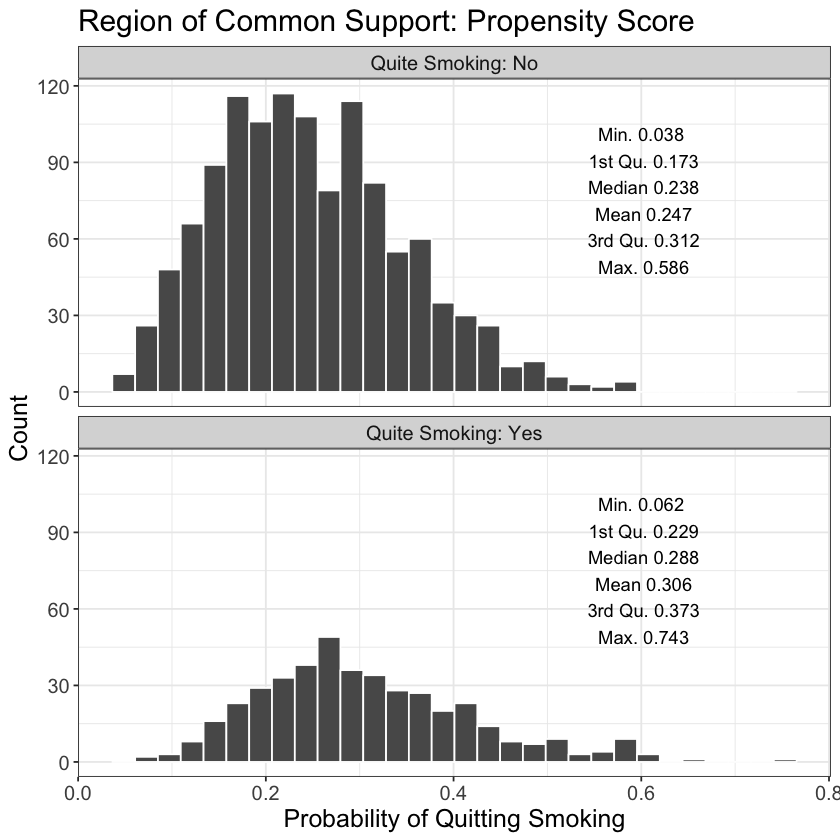

In [280]:
#plot from the dataset itself using the pipe function %>%
#we mutate the data so that people with qsmk==1 get a label of quit smoking, else no quit smk
#plot the propensity score as a histogram
#use facet_wrap to plot separate the histograms for smoking status
#use geom_text to add the summary information about the PS to the corner of the plot
ps_pred %>%
  mutate(qsmk = ifelse(qsmk==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x = ps_score)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~qsmk, nrow=2, ncol=1) + 
  xlab("Probability of Quitting Smoking") + 
  ylab("Count") + 
  ggtitle("Region of Common Support: Propensity Score") + 
  geom_text(data = ps_pred_total, aes(x=0.6, y=75, label=lab, group=NULL)) + 
  theme_bw() + 
  theme(text = element_text(size=15))

In [281]:
###########################################################################################
######### Set up columns of predicted probabilities
###########################################################################################

### create column of predicted probabilities of response from model
### and set into a column called ps_qsmk  (qsmk = quit smoking)
### state data you're using is the results from manualPS model, and to set into newdata (dataframe)
df_includeCovar$ps_qsmk = predict(manualPS, newdata=df_includeCovar, type="response")

### created predicted prob of not being assigned (1-p)
df_includeCovar$ps_notqsmk = 1 - df_includeCovar$ps_qsmk

### create an assignment column, where we assign p and 1-p into a single column
### first set the ps assignment for those who quit smoking
df_includeCovar$pAssign = df_includeCovar$ps_qsmk

### replace the column value to 1-p for those who quit smoking
df_includeCovar$pAssign[df_includeCovar$qsmk == 0] = df_includeCovar$ps_notqsmk[df_includeCovar$qsmk == 0]

In [316]:
###########################################################################################
######### Use Matching package to match the PS's we manually created
######### NO CALIPER
###########################################################################################

### Matching Package - without caliper distance
ps_MatchPkg = Match(Tr = (df_includeCovar$qsmk == 1), ### treatment
                    X = log(df_includeCovar$ps_qsmk/df_includeCovar$ps_notqsmk), ### log(ps / 1-ps)
                    M = 1, ### 1:1 matching
                    caliper = NULL, ### no caliper distance set
                    replace = F, ### no replacement
                    ties = T, ### true that PS's can be tied for treated/untreated
                    version = "fast") 

### pull out the matched data by their index as treated and control (given from Match package) by rows
ps_MatchIndex = df_includeCovar[unlist(ps_MatchPkg[c("index.treated","index.control")]) , ]

### CreateTableOne
ps_MatchPkg_T1 = CreateTableOne(vars = covars_only, ### use variables of interest in Table 1
                                strata = "qsmk", ### stratify by treatment exposure
                                data = ps_MatchIndex, ### data is our indexed data from above 
                                test = F) ### no hypothesis tests

#print table 1
print("Matching: No Caliper")
print(ps_MatchPkg_T1, smd = TRUE)

###########################################################################################
######### Use Matching package to match the PS's we manually created
######### CALIPER
###########################################################################################

### Matching Package - with caliper distance
ps_MatchPkg_C = Match(Tr = (df_includeCovar$qsmk == 1), ### treatment
                      X = log(df_includeCovar$ps_qsmk/df_includeCovar$ps_notqsmk), ### log(ps / 1-ps)
                      M = 1, ### 1:1 matching
                      caliper = 0.2, ### caliper distance of 0.2 * sd(logit(ps)) 
                      replace = F, ### no replacement
                      ties = T, ### true that PS's can be tied for treated/untreated
                      version = "fast") 

### pull out the matched data by their index as treated and control (given from Match package) by rows
ps_MatchIndex_C = df_includeCovar[unlist(ps_MatchPkg_C[c("index.treated","index.control")]) , ]

### CreateTableOne
ps_MatchPkg_T1_C = CreateTableOne(vars = covars_only, ### use variables of interest in Table 1
                                  strata = "qsmk", ### stratify by treatment exposure
                                  data = ps_MatchIndex_C, ### data is our indexed data from above 
                                  test = F) ### no hypothesis tests

#print table 1
print("--------------------------------------------------------------")
print("Matching: Caliper=0.2")
print(ps_MatchPkg_T1_C, smd = TRUE)

[1] "Matching: No Caliper"
                            Stratified by qsmk
                             0             1             SMD   
  n                            428           428               
  active (mean (sd))          0.68 (0.65)   0.69 (0.66)   0.018
  age (mean (sd))            46.85 (12.14) 46.70 (12.52)  0.012
  alcoholfreq (mean (sd))     1.93 (1.35)   1.95 (1.32)   0.014
  alcoholhowmuch (mean (sd))  2.87 (2.13)   2.91 (2.21)   0.019
  alcoholtype (mean (sd))     2.54 (1.21)   2.52 (1.20)   0.014
  education (mean (sd))       2.72 (1.19)   2.75 (1.28)   0.023
  exercise (mean (sd))        1.22 (0.75)   1.25 (0.72)   0.038
  income (mean (sd))         18.10 (2.65)  18.09 (2.45)   0.005
  race (mean (sd))            0.10 (0.30)   0.09 (0.28)   0.040
  sex (mean (sd))             0.43 (0.50)   0.45 (0.50)   0.033
  smokeintensity (mean (sd)) 18.99 (11.01) 18.79 (12.26)  0.016
  smokeyrs (mean (sd))       26.79 (12.38) 26.61 (13.03)  0.014
  wt71 (mean (sd))           7

In [283]:
###########################################################################################
######### Use MatchIt package to match the PS's we manually created
######### NO CALIPER
###########################################################################################

### MatchIt Package - nearest neighbors without caliper (automatic PS calculation)
ps_MatchItReg = matchit(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                               alcoholtype + wt71 + education + exercise + income +
                               race + sex + smokeintensity + smokeyrs + tax71 + price71,
                        method = "nearest", 
                        data = df_includeCovar)

### match the scores
ps_MatchIt = match.data(ps_MatchItReg)

#CreateTableOne - matchit without caliper
ps_MatchIt_T1 = CreateTableOne(vars = covars_only, 
                              strata = "qsmk", 
                              data = ps_MatchIt, 
                              test = F)

#print table 1
print("MatchIt: No Caliper")
print(ps_MatchIt_T1, smd = TRUE)

###########################################################################################
######### Use MatchIt package to match the PS's we manually created
######### CALIPER
###########################################################################################

### MatchIt Package - nearest neighbors with caliper (automatic PS calculation)
ps_MatchItReg_C = matchit(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                              alcoholtype + wt71 + education + exercise + income +
                              race + sex + smokeintensity + smokeyrs + tax71 + price71,
                       method = "nearest", 
                       caliper = 0.2,
                       data = df_includeCovar)

### match the scores
ps_MatchIt_C = match.data(ps_MatchItReg_C)

#CreateTableOne - matchitwith caliper
ps_MatchIt_T1_C = CreateTableOne(vars = covars_only, 
                                 strata = "qsmk", 
                                 data = ps_MatchIt_C, 
                                 test = F)

#print table 1
print("--------------------------------------------------------------")
print("MatchIt: No Caliper")
print(ps_MatchIt_T1_C, smd = TRUE)

[1] "MatchIt: No Caliper"
                            Stratified by qsmk
                             0             1             SMD   
  n                            428           428               
  active (mean (sd))          0.70 (0.66)   0.69 (0.66)   0.014
  age (mean (sd))            46.40 (12.18) 46.70 (12.52)  0.024
  alcoholfreq (mean (sd))     1.99 (1.35)   1.95 (1.32)   0.028
  alcoholhowmuch (mean (sd))  2.87 (2.30)   2.91 (2.21)   0.020
  alcoholtype (mean (sd))     2.56 (1.20)   2.52 (1.20)   0.033
  education (mean (sd))       2.75 (1.18)   2.75 (1.28)  <0.001
  exercise (mean (sd))        1.24 (0.72)   1.25 (0.72)   0.013
  income (mean (sd))         18.14 (2.52)  18.09 (2.45)   0.022
  race (mean (sd))            0.09 (0.29)   0.09 (0.28)   0.008
  sex (mean (sd))             0.46 (0.50)   0.45 (0.50)   0.019
  smokeintensity (mean (sd)) 18.64 (10.43) 18.79 (12.26)  0.014
  smokeyrs (mean (sd))       26.51 (12.15) 26.61 (13.03)  0.008
  wt71 (mean (sd))           71

In [394]:
###########################################################################################
######### Use IPW package to do STABILIZED WEIGHTING
###########################################################################################

### ipw model
iptw_stabilized = ipwpoint(exposure = qsmk, family="binomial", link="logit", 
                                       numerator = ~ 1, ### expressing this tells R to do stabilized
                                       denominator = ~ active + age + alcoholfreq + alcoholhowmuch + 
                                                       alcoholtype + wt71 + education + exercise + income +
                                                       race + sex + smokeintensity + smokeyrs + tax71 + price71, 
                                       data=df_includeCovar)

### summary stabilized IPW weights
print("Stabilized IPW")
summary(iptw_stabilized$ipw.weights)

### summary of the IPW stabilized model
summary(iptw_stabilized$den.mod)

### assign the sipw weights
df_includeCovar$sw = iptw_stabilized$ipw.weights


###########################################################################################
######### Use IPW package to do UNSTABILIZED WEIGHTING
###########################################################################################

### ipw unstabilized model
iptw_unstabilized = ipwpoint(exposure = qsmk, family="binomial", link="logit", 
                             denominator = ~ active + age + alcoholfreq + alcoholhowmuch + 
                                             alcoholtype + wt71 + education + exercise + income +
                                             race + sex + smokeintensity + smokeyrs + tax71 + price71, 
                             data=df_includeCovar)

### summary of the unstabilized IPW weights
print("")
print("Unstabilized IPW")
summary(iptw_unstabilized$ipw.weights)

### summary of the IPW unstabilized model
summary(iptw_unstabilized$den.mod)

### assign the sipw weights
df_includeCovar$ipw = iptw_unstabilized$ipw.weights

[1] "Stabilized IPW"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3537  0.8699  0.9592  0.9982  1.0830  4.2660 


Call:
glm(formula = qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
    alcoholtype + wt71 + education + exercise + income + race + 
    sex + smokeintensity + smokeyrs + tax71 + price71, family = "logit", 
    data = df_includeCovar, na.action = na.fail)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3276  -0.8195  -0.6532   1.1309   2.3610  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -2.274508   1.222221  -1.861 0.062749 .  
active          0.066310   0.092933   0.714 0.475523    
age             0.049137   0.009686   5.073 3.91e-07 ***
alcoholfreq     0.050810   0.057525   0.883 0.377094    
alcoholhowmuch -0.015391   0.025944  -0.593 0.553028    
alcoholtype    -0.013660   0.063787  -0.214 0.830425    
wt71            0.006146   0.004168   1.474 0.140353    
education       0.070710   0.056861   1.244 0.213666    
exercise        0.163862   0.085950   1.906 0.056588 .  
income          0.036033   0.026644   

[1] ""
[1] "Unstabilized IPW"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.039   1.245   1.406   1.994   2.034  16.240 


Call:
glm(formula = qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
    alcoholtype + wt71 + education + exercise + income + race + 
    sex + smokeintensity + smokeyrs + tax71 + price71, family = "logit", 
    data = df_includeCovar, na.action = na.fail)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3276  -0.8195  -0.6532   1.1309   2.3610  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -2.274508   1.222221  -1.861 0.062749 .  
active          0.066310   0.092933   0.714 0.475523    
age             0.049137   0.009686   5.073 3.91e-07 ***
alcoholfreq     0.050810   0.057525   0.883 0.377094    
alcoholhowmuch -0.015391   0.025944  -0.593 0.553028    
alcoholtype    -0.013660   0.063787  -0.214 0.830425    
wt71            0.006146   0.004168   1.474 0.140353    
education       0.070710   0.056861   1.244 0.213666    
exercise        0.163862   0.085950   1.906 0.056588 .  
income          0.036033   0.026644   

In [393]:
tail(df_includeCovar)

,qsmk,sex,age,race,income,education,wt71,smokeintensity,smokeyrs,alcoholfreq,⋯,active,exercise,price71,tax71,id,ps_qsmk,ps_notqsmk,pAssign,sw,ipw
1624,0,1,47,0,16,1,84.94,20,31,4,⋯,0,0,2.167969,1.0498047,1624,0.1732292,0.8267708,0.8267708,0.8917370,1.209525
1625,0,0,45,0,16,1,63.05,40,29,2,⋯,0,0,2.167969,1.0498047,1625,0.1481104,0.8518896,0.8518896,0.8654433,1.173861
1626,0,1,47,0,18,1,57.72,20,31,3,⋯,0,0,2.167969,1.0498047,1626,0.1532994,0.8467006,0.8467006,0.8707472,1.181055
1627,0,1,51,0,15,3,62.71,40,30,4,⋯,0,0,1.800781,0.7349854,1627,0.1427959,0.8572041,0.8572041,0.8600777,1.166583
1628,0,0,68,0,13,1,52.39,15,46,2,⋯,1,1,2.167969,1.0498047,1628,0.3984079,0.6015921,0.6015921,1.2255184,1.662256
1629,1,0,29,0,19,2,90.83,30,14,2,⋯,1,1,2.167969,1.0498047,1629,0.2060932,0.7939068,0.2060932,1.2748501,4.852175


In [391]:
###########################################################################################
######### Survey Design package to assess IPW population (UNSTABILIZED) and create table 1
###########################################################################################

### setup the IPW model with svydesign package (this does a regression using robust SEs)
### we need to run a regression to reweight the population, then we can check balance on this new population
ipw_unstabilized_svy = svydesign(ids = ~ 1, 
                                 data = df_includeCovar, 
                                 weights = ~ ipw)

### table 1
ipwTableOne_unstabilized = svyCreateTableOne(vars = covars_only, 
                                             strata="qsmk", 
                                             data=ipw_unstabilized_svy, 
                                             test=F)

### print table 1
print("Unstabilized Table 1")
print(ipwTableOne_unstabilized, smd=T)

###########################################################################################
######### Survey Design package to assess IPW population (UNSTABILIZED) and create table 1
###########################################################################################

### regression model
ipw_stabilized_svy = svydesign(ids = ~ 1, 
                               data = df_includeCovar, 
                               weights = ~ sw)

### table 1
ipwTableOne_stabilized = svyCreateTableOne(vars = covars_only, 
                                 strata="qsmk", 
                                 data=ipw_stabilized_svy, 
                                 test=F)

### print table 1
print("--------------------------------------------------------------")
print("Stabilized Table 1")
print(ipwTableOne_stabilized, smd=T)

[1] "Unstabilized Table 1"
                            Stratified by qsmk
                             0               1               SMD   
  n                          1627.93         1621.11               
  active (mean (sd))            0.65 (0.65)     0.66 (0.64)   0.016
  age (mean (sd))              43.89 (12.10)   44.13 (12.32)  0.019
  alcoholfreq (mean (sd))       1.92 (1.31)     1.92 (1.31)  <0.001
  alcoholhowmuch (mean (sd))    3.04 (2.62)     2.93 (2.16)   0.043
  alcoholtype (mean (sd))       2.48 (1.21)     2.51 (1.19)   0.028
  education (mean (sd))         2.71 (1.17)     2.75 (1.24)   0.032
  exercise (mean (sd))          1.19 (0.74)     1.19 (0.71)   0.002
  income (mean (sd))           17.97 (2.66)    18.04 (2.46)   0.026
  race (mean (sd))              0.13 (0.34)     0.14 (0.34)   0.009
  sex (mean (sd))               0.51 (0.50)     0.51 (0.50)   0.002
  smokeintensity (mean (sd))   20.58 (11.41)   20.40 (12.95)  0.015
  smokeyrs (mean (sd))         24.88 (11.9

In [408]:
###########################################################################################
######### Manipulating summary information for IPW
###########################################################################################
### weights for those who quit smoking (summary: min max quartiles)
### pull the weights from the data frame (weights = stipw)
### paste the summary information and set the annotations into a dataframe
ipw1 = summary(df_includeCovar$ipw[df_includeCovar$qsmk==1])
ipw1_format = paste(names(ipw1), format(ipw1, digits=2), collapse="\n ")
annotate_ipw1 = data.frame(x=3.5, y=300, lab = ipw1_format,
                           qsmk = factor(labelsCS[1], levels=c(labelsCS[1], labelsCS[2])))
### check the data
ipw1_format; annotate_ipw1


### weights for those who didnt quit smoking (summary: min max quartiles)
ipw0 = summary(df_includeCovar$ipw[df_includeCovar$qsmk==0])
ipw0_format = paste(names(ipw0), format(ipw0, digits=2), collapse="\n ")
annotate_ipw0 = data.frame(x=3.5, y=300, lab = ipw0_format,
                        qsmk = factor(labelsCS[2], levels=c(labelsCS[1], labelsCS[2])))
### check the data
ipw0_format; annotate_ipw0

### bind the annotated summaries for the weights where qsmk==1 and qsmk==0
ipw_total = rbind(annotate_ipw1, annotate_ipw0); ipw_total

###########################################################################################
######### Manipulating summary information for SW
###########################################################################################
### weights for those who quit smoking (summary: min max quartiles)
### pull the weights from the data frame (weights = stipw)
### paste the summary information and set the annotations into a dataframe
sw1 = summary(df_includeCovar$sw[df_includeCovar$qsmk==1])
sw1_format = paste(names(sw1), format(sw1, digits=2), collapse="\n ")
annotate_sw1 = data.frame(x=3.5, y=300, lab = sw1_format,
                          qsmk = factor(labelsCS[1], levels=c(labelsCS[1], labelsCS[2])))
### check the data
sw1_format; annotate_sw1


### weights for those who didnt quit smoking (summary: min max quartiles)
sw0 = summary(df_includeCovar$sw[df_includeCovar$qsmk==0])
sw0_format = paste(names(sw0), format(sw0, digits=2), collapse="\n ")
annotate_sw0 = data.frame(x=3.5, y=300, lab = sw0_format,
                          qsmk = factor(labelsCS[2], levels=c(labelsCS[1], labelsCS[2])))
### check the data
sw0_format; annotate_sw0

### bind the annotated summaries for the weights where qsmk==1 and qsmk==0
sw_total = rbind(annotate_sw1, annotate_sw0); sw_total

[1] "Min.  1.3\n 1st Qu.  2.7\n Median  3.5\n Mean  3.8\n 3rd Qu.  4.4\n Max. 16.2"

x,y,lab,qsmk
3.5,300,Min. 1.3 1st Qu. 2.7 Median 3.5 Mean 3.8 3rd Qu. 4.4 Max. 16.2,Quite Smoking: Yes


[1] "Min. 1.0\n 1st Qu. 1.2\n Median 1.3\n Mean 1.4\n 3rd Qu. 1.5\n Max. 2.4"

x,y,lab,qsmk
3.5,300,Min. 1.0 1st Qu. 1.2 Median 1.3 Mean 1.4 3rd Qu. 1.5 Max. 2.4,Quite Smoking: No


x,y,lab,qsmk
3.5,300,Min. 1.3 1st Qu. 2.7 Median 3.5 Mean 3.8 3rd Qu. 4.4 Max. 16.2,Quite Smoking: Yes
3.5,300,Min. 1.0 1st Qu. 1.2 Median 1.3 Mean 1.4 3rd Qu. 1.5 Max. 2.4,Quite Smoking: No


[1] "Min. 0.35\n 1st Qu. 0.70\n Median 0.91\n Mean 1.00\n 3rd Qu. 1.15\n Max. 4.27"

x,y,lab,qsmk
3.5,300,Min. 0.35 1st Qu. 0.70 Median 0.91 Mean 1.00 3rd Qu. 1.15 Max. 4.27,Quite Smoking: Yes


[1] "Min. 0.77\n 1st Qu. 0.89\n Median 0.97\n Mean 1.00\n 3rd Qu. 1.07\n Max. 1.78"

x,y,lab,qsmk
3.5,300,Min. 0.77 1st Qu. 0.89 Median 0.97 Mean 1.00 3rd Qu. 1.07 Max. 1.78,Quite Smoking: No


x,y,lab,qsmk
3.5,300,Min. 0.35 1st Qu. 0.70 Median 0.91 Mean 1.00 3rd Qu. 1.15 Max. 4.27,Quite Smoking: Yes
3.5,300,Min. 0.77 1st Qu. 0.89 Median 0.97 Mean 1.00 3rd Qu. 1.07 Max. 1.78,Quite Smoking: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


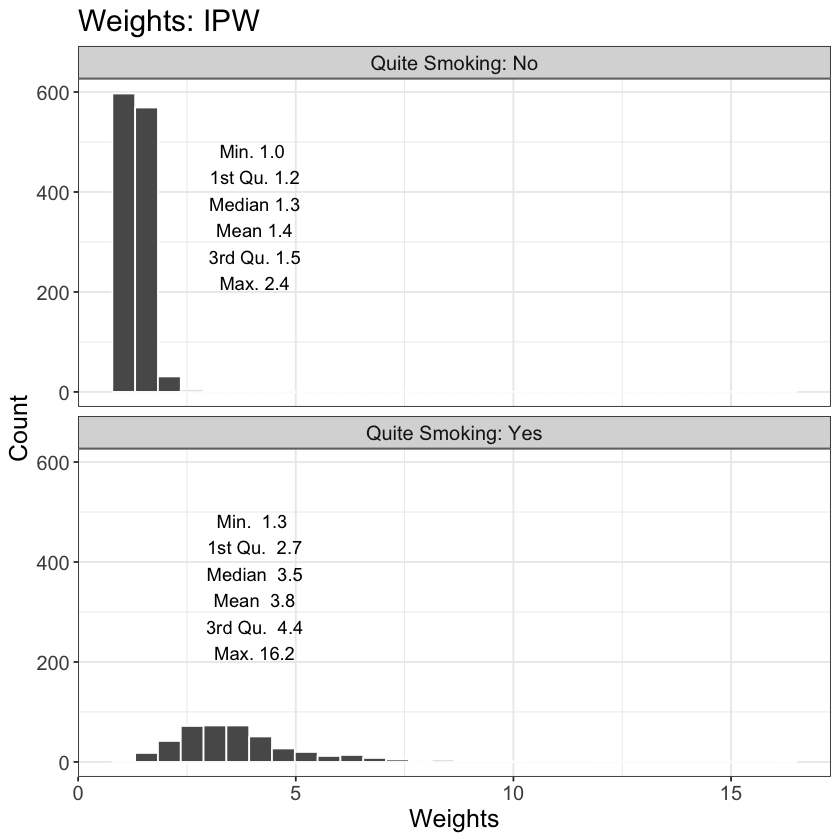

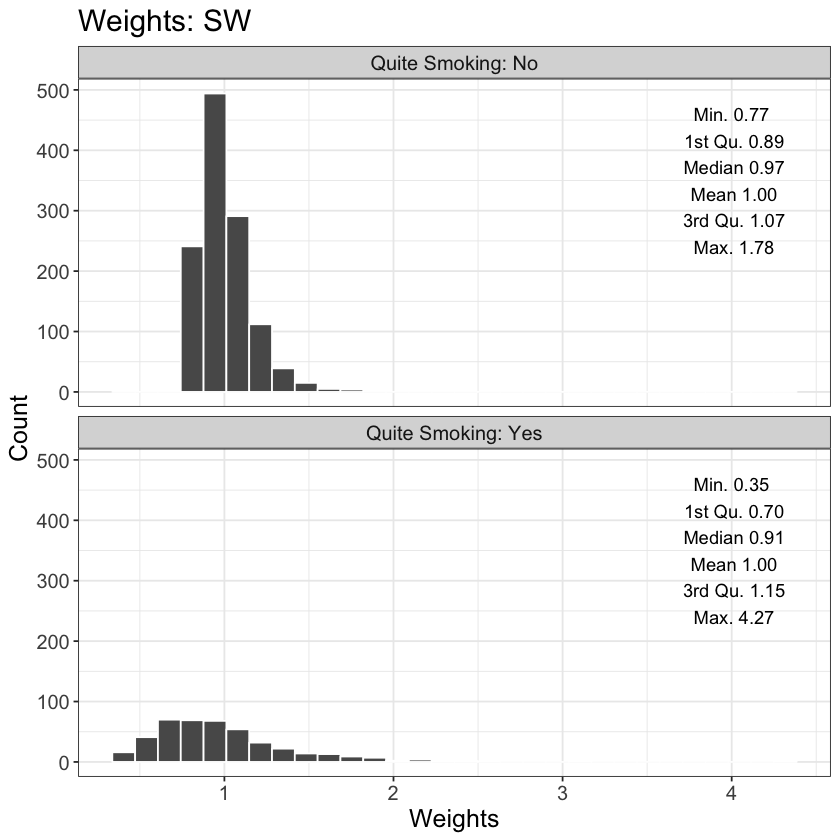

In [410]:
###########################################################################################
######### IPW weights
###########################################################################################
#plot from the dataset itself using the pipe function %>%
#we mutate the data so that people with qsmk==1 get a label of quit smoking, else no quit smk
#plot the weight as a histogram
#use facet_wrap to plot separate the histograms for smoking status
#use geom_text to add the summary information about the weight to the corner of the plot
df_includeCovar %>%
  mutate(qsmk = ifelse(qsmk==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x = ipw)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~qsmk, nrow=2, ncol=1) + 
  xlab("Weights") + 
  ylab("Count") + 
  ggtitle("Weights: IPW") + 
  geom_text(data = ipw_total, aes(x=4, y=350, label=lab, group=NULL)) +
  theme_bw() + 
  theme(text = element_text(size=15))

###########################################################################################
######### SW weights
###########################################################################################
#plot from the dataset itself using the pipe function %>%
#we mutate the data so that people with qsmk==1 get a label of quit smoking, else no quit smk
#plot the weight as a histogram
#use facet_wrap to plot separate the histograms for smoking status
#use geom_text to add the summary information about the weight to the corner of the plot
df_includeCovar %>%
  mutate(qsmk = ifelse(qsmk==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x = sw)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~qsmk, nrow=2, ncol=1) + 
  xlab("Weights") + 
  ylab("Count") + 
  ggtitle("Weights: SW") + 
  geom_text(data = sw_total, aes(x=4, y=350, label=lab, group=NULL)) +
  theme_bw() + 
  theme(text = element_text(size=15))

In [288]:
###########################################################################################
######### Aggregate tables to plot the standardized mean differences of covariates
###########################################################################################

### pull the information from each of the tables and set it into a dataframe using extractsmd()
smdPlot = data.frame(Covariates = names(ExtractSmd(unmatchedTableOne)),
                     Unmatched = ExtractSmd(unmatchedTableOne),
                     PS.MatchIt = ExtractSmd(ps_MatchIt_T1),
                     PS.MatchIt.C = ExtractSmd(ps_MatchIt_T1_C),                      
                     PS.Matched = ExtractSmd(ps_MatchPkg_T1),
                     PS.Matched.C = ExtractSmd(ps_MatchPkg_T1_C),
                     IPW = ExtractSmd(ipwTableOne_unstabilized),
                     SW = ExtractSmd(ipwTableOne_stabilized))

### use the melt function to change/transform the data into something we can plot
### melt is the same function you use to transform from wide to long formats (longitudinal data)
smdPlotMelt = melt(data = smdPlot,
                   id.vars = c("Covariates"),
                   variable.name = "Method",
                   value.name = "SMD")

### set the variable names and order them by what's in the unmatched data (defined in changePlt)
var.Names = as.character(smdPlot$Covariates[order(smdPlot$Unmatched)])

### set up the factors of the variables for plotting (pulls each var out of the list)
smdPlotMelt$Covariates = factor(smdPlotMelt$Covariates, levels=var.Names)

### add more levels to factor
levels(smdPlotMelt$Method) <- c(levels(smdPlotMelt$Method), c("MatchIt Pkg (no caliper)",
                                                              "MatchIt Pkg (caliper=0.2)",
                                                              "PS Matching (no caliper)",
                                                              "PS Matching (caliper=0.2)"))

### rename Method values to look better in plot
smdPlotMelt$Method[smdPlotMelt$Method=="PS.MatchIt"] = "MatchIt Pkg (no caliper)"
smdPlotMelt$Method[smdPlotMelt$Method=="PS.MatchIt.C"] = "MatchIt Pkg (caliper=0.2)"
smdPlotMelt$Method[smdPlotMelt$Method=="PS.Matched"] = "PS Matching (no caliper)"
smdPlotMelt$Method[smdPlotMelt$Method=="PS.Matched.C"] = "PS Matching (caliper=0.2)"

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them.”Warning message:
“Removed 15 rows containing missing values (geom_point).”

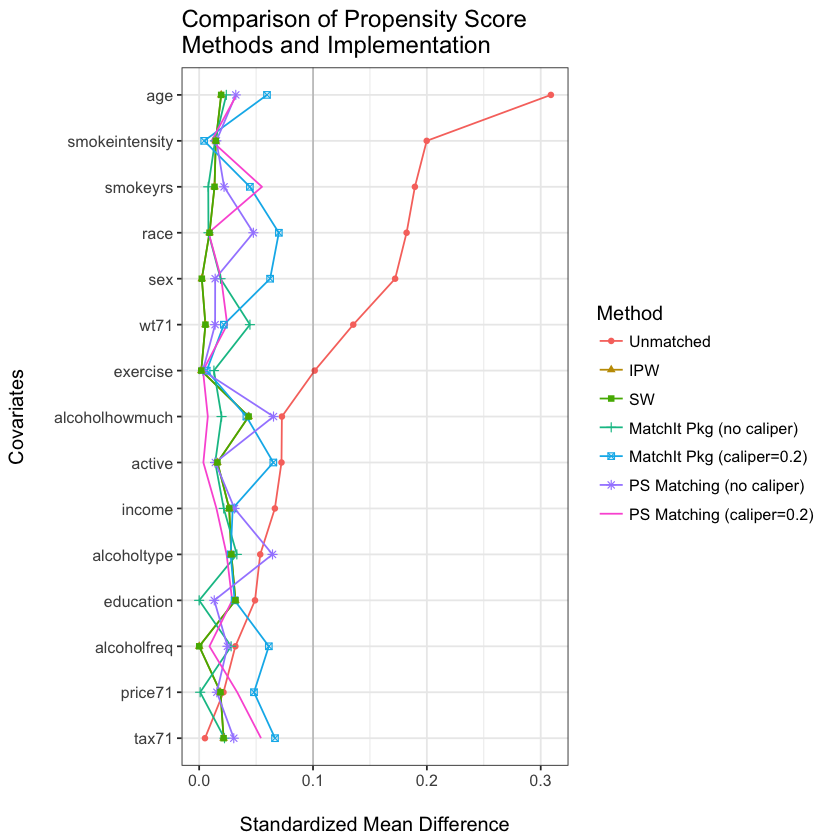

In [289]:
### plot
options(jupyter.plot_mimetypes = 'image/png')

smdPlotMelt %>%
    ggplot(aes(x = Covariates, y = SMD, group = Method, color = Method, shape=Method)) + 
    geom_line() + 
    geom_point() + 
    geom_hline(yintercept = 0.1, color = "black", size = 0.1) + 
    coord_flip() + 
    theme_bw() + 
    ggtitle("Comparison of Propensity Score\nMethods and Implementation") +
    xlab("Covariates\n") + 
    ylab("\nStandardized Mean Difference") +
    theme(legend.key = element_blank(), 
          text = element_text(size=12),
          axis.title = element_text(size = 12, color="black"))    

In [297]:
#merge data back together
merged_df = merge(df_outcomeOnly, df_includeCovar, by="id")

In [293]:
### merge data for ps matched data
matchingPopulation = merge(df_outcomeOnly, ps_MatchIndex, by="id")

### perform regression
ps_regression_matching = glm(wt82_71 ~ qsmk, data=matchingPopulation)

### summary and confidence intervals
summary(ps_regression_matching); confint(ps_regression_matching)


Call:
glm(formula = wt82_71 ~ qsmk, data = matchingPopulation)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-31.912   -4.073   -0.052    4.488   42.986  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.4104     0.3959   3.563 0.000388 ***
qsmk          3.1147     0.5623   5.540  4.1e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 64.24959)

    Null deviance: 54078  on 812  degrees of freedom
Residual deviance: 52106  on 811  degrees of freedom
  (43 observations deleted due to missingness)
AIC: 5695.5

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.6344852,2.186234
qsmk,2.0127132,4.216726


In [318]:
### merge data for ps matched data with caliper
matchingPopulation_C = merge(df_outcomeOnly, ps_MatchIndex_C, by="id")

### perform regression
ps_regression_matching_C = glm(wt82_71 ~ qsmk, data=matchingPopulation_C)

### summary and confidence intervals
summary(ps_regression_matching_C); confint(ps_regression_matching_C)


Call:
glm(formula = wt82_71 ~ qsmk, data = matchingPopulation_C)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-31.680   -4.208   -0.131    4.522   42.861  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.6302     0.3923   4.156 3.59e-05 ***
qsmk          3.0200     0.5576   5.416 8.08e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 61.55188)

    Null deviance: 50432  on 791  degrees of freedom
Residual deviance: 48626  on 790  degrees of freedom
  (38 observations deleted due to missingness)
AIC: 5514.5

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.8613969,2.399087
qsmk,1.9271773,4.112866


In [313]:
### merge data for ps matched data with caliper
matchitPopulation = merge(df_outcomeOnly, ps_MatchIt, by="id")

### perform regression
ps_regression_matchit = glm(wt82_71 ~ qsmk, data=matchitPopulation)

### summary and confidence intervals
summary(ps_regression_matchit); confint(ps_regression_matchit)


Call:
glm(formula = wt82_71 ~ qsmk, data = matchitPopulation)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-31.990   -4.003   -0.010    4.417   42.986  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.4877     0.3871   3.843 0.000131 ***
qsmk          3.0374     0.5495   5.528 4.37e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 61.28578)

    Null deviance: 51514  on 811  degrees of freedom
Residual deviance: 49641  on 810  degrees of freedom
  (44 observations deleted due to missingness)
AIC: 5650.2

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.7290333,2.246420
qsmk,1.9604116,4.114293


In [319]:
### merge data for ps matched data with caliper
matchitPopulation_C = merge(df_outcomeOnly, ps_MatchIt_C, by="id")

### perform regression
ps_regression_matchit_C = glm(wt82_71 ~ qsmk, data=matchitPopulation_C)

### summary and confidence intervals
summary(ps_regression_matchit_C); confint(ps_regression_matchit_C)


Call:
glm(formula = wt82_71 ~ qsmk, data = matchitPopulation_C)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-27.629   -4.153   -0.072    4.582   42.859  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.6588     0.4008   4.139 3.86e-05 ***
qsmk          2.9937     0.5693   5.258 1.87e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 64.5754)

    Null deviance: 53123  on 796  degrees of freedom
Residual deviance: 51337  on 795  degrees of freedom
  (39 observations deleted due to missingness)
AIC: 5587.5

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.8733068,2.444388
qsmk,1.8778945,4.109561


In [325]:
### have to use the survey design package for weighted data
ipw_rg = (svyglm(wt82_71 ~ qsmk, design = svydesign(~1, weights=~ipw,
          data=merged_df)))

### summary and confidence intervals
summary(ipw_rg); confint(ipw_rg)


Call:
svyglm(formula = wt82_71 ~ qsmk, design = svydesign(~1, weights = ~ipw, 
    data = merged_df))

Survey design:
svydesign(~1, weights = ~ipw, data = merged_df)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.7882     0.2222   8.049 1.64e-15 ***
qsmk          3.2703     0.5220   6.265 4.80e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 64.7786)

Number of Fisher Scoring iterations: 2


,2.5 %,97.5 %
(Intercept),1.352710,2.223604
qsmk,2.247239,4.293301


In [326]:
### have to use the survey design package for weighted data
sw_rg = (svyglm(wt82_71 ~ qsmk, design = svydesign(~1, weights=~sw,
          data=merged_df)))

### summary and confidence intervals
summary(sw_rg); confint(sw_rg)


Call:
svyglm(formula = wt82_71 ~ qsmk, design = svydesign(~1, weights = ~sw, 
    data = merged_df))

Survey design:
svydesign(~1, weights = ~sw, data = merged_df)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.7882     0.2222   8.049 1.64e-15 ***
qsmk          3.2703     0.5220   6.265 4.80e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 60.66354)

Number of Fisher Scoring iterations: 2


,2.5 %,97.5 %
(Intercept),1.352710,2.223604
qsmk,2.247239,4.293301


In [305]:
### define a stratum for the PS to take on deciles (as a vector)
strat = quantile(merged_df$pAssign, probs=c(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9))

### set the stratums range of PS
strat1 = merged_df$ps_qsmk <= strat[1]
strat2 = merged_df$ps_qsmk > strat[1] & merged_df$ps_qsmk <= strat[2]
strat3 = merged_df$ps_qsmk > strat[2] & merged_df$ps_qsmk <= strat[3]
strat4 = merged_df$ps_qsmk > strat[3] & merged_df$ps_qsmk <= strat[4]
strat5 = merged_df$ps_qsmk > strat[4] & merged_df$ps_qsmk <= strat[5]
strat6 = merged_df$ps_qsmk > strat[5] & merged_df$ps_qsmk <= strat[6]
strat7 = merged_df$ps_qsmk > strat[6] & merged_df$ps_qsmk <= strat[7]
strat8 = merged_df$ps_qsmk > strat[7] & merged_df$ps_qsmk <= strat[8]
strat9 = merged_df$ps_qsmk > strat[8] & merged_df$ps_qsmk <= strat[9]
strat10 = merged_df$ps_qsmk > strat[9]

### setup of the a single variable to take on categorical values
merged_df$stratvar = numeric(length(merged_df$qsmk))

### assign the categorical values through a forloop
### for i = 1 until the max length of the dataset, assign values
for (i in 1:length(merged_df$qsmk)) {
    if (strat1[i]==T) {merged_df$stratvar[i] = 1}
    else if (strat2[i]==T) {merged_df$stratvar[i] = 2}
    else if (strat3[i]==T) {merged_df$stratvar[i] = 3}
    else if (strat4[i]==T) {merged_df$stratvar[i] = 4}
    else if (strat5[i]==T) {merged_df$stratvar[i] = 5}
    else if (strat6[i]==T) {merged_df$stratvar[i] = 6}
    else if (strat7[i]==T) {merged_df$stratvar[i] = 7}
    else if (strat8[i]==T) {merged_df$stratvar[i] = 8}
    else if (strat9[i]==T) {merged_df$stratvar[i] = 9}
    else merged_df$stratvar[i] = 10
}
    
### regression as deciles
strmodel1 = glm(wt82_71 ~ qsmk + as.factor(stratvar), data = merged_df)
summary(strmodel1); confint(strmodel1)


Call:
glm(formula = wt82_71 ~ qsmk + as.factor(stratvar), data = merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-42.261   -4.151   -0.092    4.082   47.558  

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2.9521     0.2798  10.552  < 2e-16 ***
qsmk                   3.2383     0.4551   7.116 1.69e-12 ***
as.factor(stratvar)2  -1.9717     0.4322  -4.562 5.47e-06 ***
as.factor(stratvar)3  -3.2893     0.6078  -5.412 7.22e-08 ***
as.factor(stratvar)4  -6.9530     2.4643  -2.822 0.004840 ** 
as.factor(stratvar)6 -27.2856     7.6923  -3.547 0.000401 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 58.96332)

    Null deviance: 97176  on 1565  degrees of freedom
Residual deviance: 91983  on 1560  degrees of freedom
  (63 observations deleted due to missingness)
AIC: 10837

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),2.403744,3.500365
qsmk,2.346354,4.130296
as.factor(stratvar)2,-2.818832,-1.124517
as.factor(stratvar)3,-4.480528,-2.097992
as.factor(stratvar)4,-11.782951,-2.123103
as.factor(stratvar)6,-42.362214,-12.208987


In [306]:
### regression as continuous - this is done on the original dataset
### its a like a unique form of multivariate regression
### where the PS captures all the covariate information
strmodel = glm(wt82_71 ~ qsmk + ps_qsmk, data=merged_df)
summary(strmodel); confint(strmodel)


Call:
glm(formula = wt82_71 ~ qsmk + ps_qsmk, data = merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-42.721   -4.116   -0.117    4.211   48.037  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.4746     0.5169  10.592  < 2e-16 ***
qsmk          3.3593     0.4566   7.358 3.01e-13 ***
ps_qsmk     -14.1476     1.8865  -7.500 1.07e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 58.81996)

    Null deviance: 97176  on 1565  degrees of freedom
Residual deviance: 91936  on 1563  degrees of freedom
  (63 observations deleted due to missingness)
AIC: 10830

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),4.461547,6.487620
qsmk,2.464440,4.254129
ps_qsmk,-17.844953,-10.450166


In [308]:
### multivariate regression
rg = glm(wt82_71 ~ qsmk + active + age + alcoholfreq + 
                   alcoholhowmuch + alcoholtype + wt71 + education + 
                   exercise + income + race + sex + smokeintensity + 
                   smokeyrs + price71 + tax71, 
         data=merged_df)

### print summary and confidence intervals
summary(rg); confint(rg)


Call:
glm(formula = wt82_71 ~ qsmk + active + age + alcoholfreq + alcoholhowmuch + 
    alcoholtype + wt71 + education + exercise + income + race + 
    sex + smokeintensity + smokeyrs + price71 + tax71, data = merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-41.789   -4.192   -0.288    3.994   45.752  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    16.65028    3.95351   4.212 2.68e-05 ***
qsmk            3.31917    0.44194   7.511 9.90e-14 ***
active         -0.55953    0.30471  -1.836  0.06651 .  
age            -0.20640    0.03317  -6.223 6.27e-10 ***
alcoholfreq     0.34832    0.18728   1.860  0.06310 .  
alcoholhowmuch -0.08624    0.07530  -1.145  0.25224    
alcoholtype    -0.31147    0.20492  -1.520  0.12874    
wt71           -0.09982    0.01373  -7.268 5.76e-13 ***
education       0.04337    0.18791   0.231  0.81748    
exercise        0.21048    0.27678   0.760  0.44709    
income          0.05186    0.084

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),8.901542455,24.39901422
qsmk,2.452992087,4.18534959
active,-1.156743425,0.03769001
age,-0.271406540,-0.14139168
alcoholfreq,-0.018749793,0.71538586
alcoholhowmuch,-0.233819338,0.06133805
alcoholtype,-0.713111095,0.09017703
wt71,-0.126732329,-0.07289891
education,-0.324920730,0.41166875
exercise,-0.331992215,0.75294838


In [312]:
### crude regression
crd = glm(wt82_71 ~ qsmk, data=merged_df)

### summary and confidence intervals
summary(crd); confint(crd)


Call:
glm(formula = wt82_71 ~ qsmk, data = merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-43.265   -4.023    0.033    4.248   46.554  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.9845     0.2288   8.672  < 2e-16 ***
qsmk          2.5406     0.4511   5.632 2.11e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 60.89757)

    Null deviance: 97176  on 1565  degrees of freedom
Residual deviance: 95244  on 1564  degrees of freedom
  (63 observations deleted due to missingness)
AIC: 10883

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),1.536002,2.432993
qsmk,1.656481,3.424682


In [402]:
### create dataframe with results so we can print out and plot
model = c("PS Matching (no caliper)", "PS Matching (caliper = 0.2)","PS MatchIt (no caliper)", "PS MatchIt (caliper = 0.2)", "Unstabilized IPW", "Stabilized IPW", "Continuous Adjustment", "Stratification (Deciles)", "Multivariate Regression", "Crude Regression")
estimates = c(3.1147, 3.0200, 3.0374, 2.9937, 3.2703, 3.2703, 3.2383, 3.3593, 3.31917, 2.5406)
lower = c(2.0127132, 1.9271773, 1.9604116, 1.8778945, 2.247239, 2.247239, 2.346354, 2.464440, 2.452992087, 1.656481)
upper = c(4.216726, 4.112866, 4.114293, 4.109561, 4.293301, 4.293301, 4.130296, 4.254129, 4.18534959, 3.424682)

In [403]:
### bind the information together that we created
estimates_list = list(model, estimates, lower, upper)
estimates_df = do.call(cbind, estimates_list)

In [404]:
### cast to a dataframe and set column names
estimates_df = data.frame(estimates_df)
names(estimates_df) = c("Model", "Estimate", "CI: Lower", "CI: Upper")

In [405]:
### format the data types as needed
estimates_df$Estimate = as.numeric(as.character(estimates_df$Estimate))
estimates_df$'CI: Lower' = as.numeric(as.character(estimates_df$'CI: Lower'))
estimates_df$'CI: Upper' = as.numeric(as.character(estimates_df$'CI: Upper'))

In [406]:
### printout
estimates_df

Model,Estimate,CI: Lower,CI: Upper
PS Matching (no caliper),3.11470,2.012713,4.216726
PS Matching (caliper = 0.2),3.02000,1.927177,4.112866
PS MatchIt (no caliper),3.03740,1.960412,4.114293
PS MatchIt (caliper = 0.2),2.99370,1.877895,4.109561
Unstabilized IPW,3.27030,2.247239,4.293301
Stabilized IPW,3.27030,2.247239,4.293301
Continuous Adjustment,3.23830,2.346354,4.130296
Stratification (Deciles),3.35930,2.464440,4.254129
Multivariate Regression,3.31917,2.452992,4.185350
Crude Regression,2.54060,1.656481,3.424682


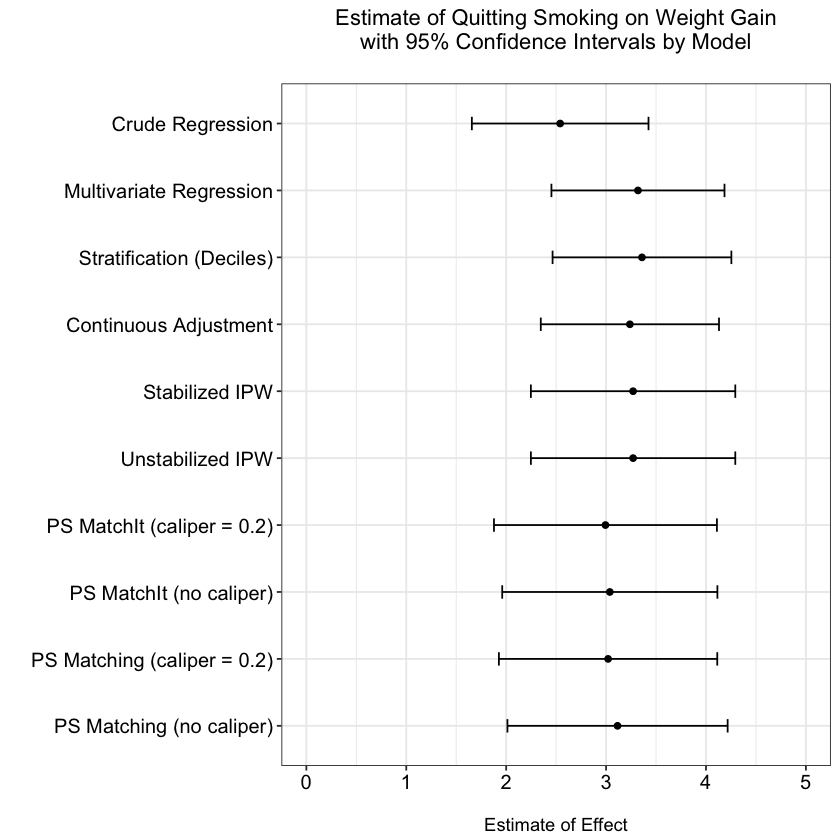

In [407]:
### create factor with levels
estimates_df$Model = factor(estimates_df$Model, 
                             levels=c("PS Matching (no caliper)", "PS Matching (caliper = 0.2)", "PS MatchIt (no caliper)", "PS MatchIt (caliper = 0.2)", "Unstabilized IPW", "Stabilized IPW", "Continuous Adjustment", "Stratification (Deciles)", "Multivariate Regression", "Crude Regression"))

### create plot of the estimates and confidence intervals
estimates_df %>%
    ggplot(aes(x=Estimate, y=Model)) + 
    geom_point() +
    geom_errorbarh(mapping=aes(xmin=estimates_df$'CI: Lower', xmax=estimates_df$'CI: Upper'), height=0.2) +
    theme_bw() + 
    theme(axis.text.x = element_text(color="black", size=12),
          axis.text.y = element_text(color="black", size=12),
          plot.title = element_text(hjust = 0.5)) +
    ylab("") +
    xlab("\nEstimate of Effect") + 
    ggtitle("Estimate of Quitting Smoking on Weight Gain\nwith 95% Confidence Intervals by Model\n") +
    xlim(0,5)